In [5]:
import numpy as np
import pandas as pd
import sys
from pathlib import Path
sys.path.append('..') 
import platform
import os
from pathlib import Path
import shutil
from utils.basics.data_org import curr_computer, move_subfolders
from pathlib import Path
import shutil
from utils.behavior.session_utils import load_session_df, parse_session_string
from utils.behavior.lick_analysis import clean_up_licks, parse_lick_trains
from scipy.io import loadmat
from itertools import chain
from matplotlib import pyplot as plt
from IPython.display import display
from scipy.signal import find_peaks
from harp.clock import align_timestamps_to_anchor_points
from utils.photometry.preprocessing import *
import numpy as np
from scipy.signal import butter, filtfilt, medfilt
from scipy.optimize import curve_fit
import json
from sklearn.linear_model import LinearRegression
# %matplotlib inline
%matplotlib widget

In [6]:
session = 'm699461d20231222'
label = 'CombinewithKH'
session_dir = parse_session_string(session)
session_df, licks_L, licks_R = load_session_df(session)
licks_L, licks_R, fig = clean_up_licks(licks_L, licks_R, plot=False)
parsed_licks_L, _ = parse_lick_trains(licks_L)
signal_region = load_session_FP(session, label)

Region mPFC recorded at fiber 0
Region LCN recorded at fiber 1
Region LC recorded at fiber 2


In [7]:
session = 'm699461d20231222'
label = 'CombinewithKH'
session_df, licks_L, licks_R = load_session_df(session)
signal_region = load_session_FP(session, label, plot=False)

Region mPFC recorded at fiber 0
Region LCN recorded at fiber 1
Region LC recorded at fiber 2


In [8]:
def load_session_FP_raw(session, label, channels = ['G', 'Iso'], plot = False):
    session_dir = parse_session_string(session)
    signal_region = load_session_FP(session, label, plot=False)
    # Directory containing the files
    fpDir = session_dir['photometryPath']
    photometry_json = os.path.join(session_dir['photometryPath'], f'{session}.json')
    with open(photometry_json, "r") as file:
        location_info = json.load(file)
    # Get all files in the directory
    allFiles = os.listdir(fpDir)

    # Filter only files (ignore directories)
    allFiles = [f for f in allFiles if not os.path.isdir(os.path.join(fpDir, f))]
    time_stamps = None
    signal_region_raw = {}
    # Load signal files
    for channel in channels: 
        curr_sig = {}
        channelInd = [f for f in allFiles if f'FIP_Data{channel}' in f]
        if len(channelInd) > 0:
            channelSigData = pd.read_csv(os.path.join(fpDir, channelInd[0]), header=None).to_numpy()
            if channel == 'G':
                time_stamps = channelSigData[:, 0]
            # curr_sig[channel] = channelSigData[:, 1:1 + len(location_info)]
            for key, value in location_info.items():
                print(f"Channel {channel}:Region {value} recorded at fiber {key}")
                curr_sig[value] = np.array(channelSigData[:, int(key)+1])
        signal_region_raw[channel] = curr_sig

    for color in channels:
        curr_sig = signal_region_raw[color]
        for key, value in location_info.items():
            curr_sig[value] = curr_sig[value][(time_stamps <= signal_region['time'][-1]) & (time_stamps >= signal_region['time'][0])]


    signal_region_raw['time'] = time_stamps
    signal_region_raw['time_in_beh'] = signal_region['time_in_beh']

    if plot:
        fig, ax = plt.subplots(len(location_info.keys()), len(channels), figsize=(10, 5))
        for i, key in enumerate(location_info.keys()):
            for j, color in enumerate(channels):
                ax[i, j].plot(signal_region_raw['time_in_beh'], signal_region_raw[color][location_info[key]], label=color)
                ax[i, j].set_title(f'{color}{key}')
                if j == 0 and i == 0:
                    ax2 = ax[i, j].twinx()
                    ax2.hist(licks_L, bins=100, alpha=0.5, label='Licks L')
                    ax2.hist(licks_R, bins=100, alpha=0.5, label='Licks R')            
                if j == 0:
                    ax[i, j].set_ylabel(location_info[key])
                if i == len(location_info.keys()) - 1:
                    ax[i, j].set_xlabel('Time (ms)')
                ax[i, j].legend()
        plt.suptitle('Alignment Check')
        plt.tight_layout()
        fig.savefig(os.path.join(session_dir['saveFigFolder'], f'{session}_alignment_check.pdf'))
        return signal_region_raw, fig
    else:
        return signal_region_raw




Region mPFC recorded at fiber 0
Region LCN recorded at fiber 1
Region LC recorded at fiber 2
Channel G:Region mPFC recorded at fiber 0
Channel G:Region LCN recorded at fiber 1
Channel G:Region LC recorded at fiber 2
Channel Iso:Region mPFC recorded at fiber 0
Channel Iso:Region LCN recorded at fiber 1
Channel Iso:Region LC recorded at fiber 2


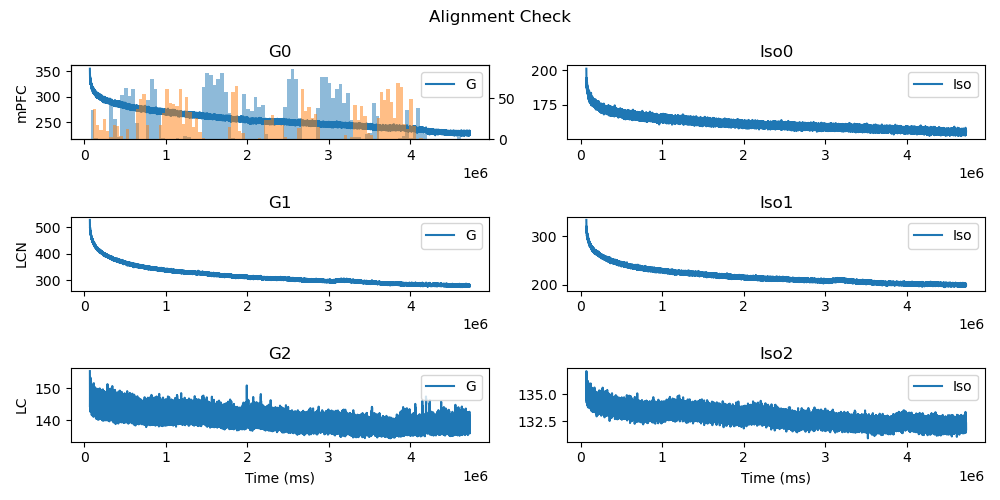

In [12]:
signal_region_raw, fig = load_session_FP_raw(session, label, channels = ['G', 'Iso'], plot = True)
fig.savefig(os.path.join(session_dir['saveFigFolder'], f'{session}_raw.pdf'))

In [ ]:
signal_region_prep, fig = preprocess_signal(session, signal_region_raw, plot=True)
plt.close('all')